In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from pandas import Series, DataFrame

C:\Users\hashi\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
# Upload the data 
opp_per100 = pd.read_table('opp_per100.txt', sep=',', header = 0)
opp_pergame = pd.read_table('opp_pergame.txt', sep=',', header = 0)
opp_shooting = pd.read_table('opp_shooting.txt', sep=',', header = 2)
team_misc = pd.read_table('team_misc.txt', sep=',', header = 1)
team_per100 = pd.read_table('team_per100.txt', sep=',', header = 0)
team_pergame = pd.read_table('team_pergame.txt', sep=',', header = 0)
team_shooting = pd.read_table('team_shooting.txt', sep=',', header = 2)

## Data Collection

I retrieved team and opponent NBA data from [Basketball-Reference](https://www.basketball-reference.com/leagues/NBA_2018.html). The data is **only for the 2018 NBA season**

## Four-Factors 

To win basketball games, Dean Oliver identified the following statistics as being essential, he called these **"Four Factors of Basketball Success"**. The number in the parenthesis is the weight Dean Oliver gave each factor

* Shooting (40%) measured using `eFG%`
* Turnovers (25%) measured using `TOV%`
* Rebounding (20%) measured using `ORB%` and `DRB%`
* Freethrows (15%) measured using `FT/ FGA` (How much % of a teams total Field Goals come from Freethrows)

Let us see how accurate we are in predicting the number of wins each team had in the 2017-18 season using these factors and weights


## Methodology

I intend on using Weighted Least Sqaures regression, assiging the weights that Dean Oliver originally proposed. Let us explore the datasets now

### Plotting the Four Factors against Wins

Let us plot each of the four factors agains wins and inspect the relationship between them

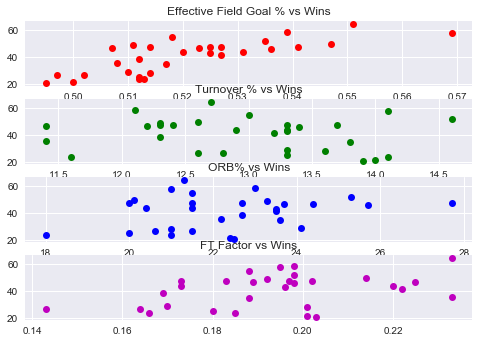

In [68]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(4, sharex = False, sharey = True)

ax1.plot(team_misc['eFG%'], team_misc['W'], 'ro')
ax1.set_title('Effective Field Goal % vs Wins')

ax2.plot(team_misc['TOV%'], team_misc['W'], 'go')
ax2.set_title('Turnover % vs Wins')

ax3.plot(team_misc['ORB%'], team_misc['W'], 'bo')
ax3.set_title('ORB% vs Wins')

ax4.plot(team_misc['FT/FGA'], team_misc['W'], 'mo')
ax4.set_title('FT Factor vs Wins')

# Fine-tune figure; make subplots close to each other

plt.show()

## Results

For all four factors, there definitely seems to be linear enough of a relationship with wins to warrant trying to create a regression model

### Model

* Our independent variables will be 
    * eFG% 
    * ORB%
    * TOV%
    * FT Factor (FT/ FGA)
* Our dependent variables will be
    * W (Wins) <br>

### Scaling The Data
We will have to scale the data as the website I collected it from does not have the four factors in the same units (%). We can do that manually as follows

In [71]:
team_misc['ORB%'] = team_misc['ORB%']/100

In [73]:
team_misc['TOV%'] = team_misc['TOV%']/100

In [74]:
from sklearn.cross_validation import train_test_split

In [75]:
# Splitting data into training and test
x_train, x_test, y_train, y_test = train_test_split(team_misc[['eFG%', 'ORB%', 'TOV%', 'FT/FGA']], team_misc['W'], test_size = 0.2, random_state = 0)

In [76]:
model = sm.OLS(y_train, x_train).fit()
predictions = model.predict(x_test)

In [77]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      W   R-squared:                       0.954
Model:                            OLS   Adj. R-squared:                  0.945
Method:                 Least Squares   F-statistic:                     104.2
Date:                Fri, 08 Jun 2018   Prob (F-statistic):           4.28e-13
Time:                        09:41:44   Log-Likelihood:                -87.475
No. Observations:                  24   AIC:                             182.9
Df Residuals:                      20   BIC:                             187.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
eFG%         162.9288     82.543      1.974      0.0

## Results

We get statistically significant `p`-values form `TOV%` and at all levels of $\alpha$ besides 0.01, and the result of our predictors we do not get statistically significant results

### Interpretations

From the coefficient estimates we see that a 1% increase is associated with a 162/100 increase in wins (1.62 wins per % increase in `eFG%`). Similar analysis can be made for `ORB%`, `TOV%`, `FT/FGA`.

A 1% increase in `ORB%` is associated with a 66.82/100 increase in wins (0.6682 wins per % increase)

A 1% increase in `TOV%` is associated with a -545.335/100 **decrease** in wins (-5.45 wins per % increase). This is a surprise and it contradicts Mr Oliver's weights that contribute to a teams win. Also, the coefficient estimate of this factor is statistically significant as well. According to our model with our small sample size `TOV%` seems to be the most important factor in effecting wins. 

Finally A 1% increase in `FT/FGA` is associated with a 0.64 win per % increase. The more often a team goes to the line and makes their FT, the likely it is it is going to contribute to a win. From our model, this is the lowest contributing factor to wins. 

### Weights 
From our model we see the most contributing factors to the number of games a team wins is as follows:

* `TOV%`
* `eFG%`
* `ORB%`
* `FT/FGA`

In [78]:
print(y_test, '\n', predictions)

2     58.0
28    27.0
13    50.0
10    46.0
26    22.0
24    25.0
Name: W, dtype: float64 
 2     42.433081
28    36.614206
13    47.653478
10    44.208262
26    33.059143
24    35.872460
dtype: float64


## Results

As we compare the predictons of our wins to the actual wins total of the teams, we see our model is several wins off. We can calculate the average amount of wins our predictions was wrong by as follows.

### Reasons

* Extremely small sample size. Our training set was 24 teams and our test was 6

In [88]:
# Average number of wins our model was wrong by
sum(abs(y_test - predictions))/6

8.5418312959138643

In [89]:
from IPython.display import display, Math, Latex

## Creating a `log-linear` model

Let us create a `log-linear` model, which mathematically looks as follows

<center> $$ log(\bf{y})  = {\bf X\beta} + {\bf \epsilon} $$</center>